# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string, ast
from enum import Enum
from typing import Any, Optional, Callable
from html import escape
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore.meta import delegates
from fastcore import imghdr
from dataclasses import dataclass
from litellm.exceptions import ContextWindowExceededError

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Markdown, Image, Audio, Video
import httpx

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase, ChatCompletionMessageToolCall
    from uuid import UUID
    from base64 import b64encode
    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic
    
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    def _unqid():
        res = b64encode(UUID(int=random.getrandbits(128), version=4).bytes)
        return '_' + res.decode().rstrip('=').translate(str.maketrans('+/', '__'))  # both to underscore for srvtoolu_ pattern

    @patch
    def __init__(self: ChatCompletionMessageToolCall, function=None, id=None, type="function", **kwargs):
        # we keep the tool call prefix if it exists, this is needed for example to handle srvtoolu_ correctly.
        id = id.split('_')[0]+_unqid() if id and '_' in id else id
        self._orig___init__(function=function, id=id, type=type, **kwargs)

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    for img in getattr(message, 'images', []): content += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})"
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
litellm.register_model({'claude-opus-4-6': litellm.model_cost['claude-opus-4-5']})
sonn45 = "claude-sonnet-4-5"
opus45 = "claude-opus-4-5"
opus46 = "claude-opus-4-6"

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-3-pro-preview", "gemini/gemini-3-flash-preview", "claude-opus-4-5", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

**gemini/gemini-3-pro-preview:**

Hello! How can I help you today? Whether you have a question, need some writing done, or just want to chat, I'm here.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=148, prompt_tokens=4, total_tokens=152, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=117, rejected_prediction_tokens=None, text_tokens=31, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**gemini/gemini-3-flash-preview:**

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=4, total_tokens=13, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None))`

</details>

**claude-opus-4-5:**

Hey! How's it going? What can I help you with today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=18, prompt_tokens=10, total_tokens=28, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Hey! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Generated images are also displayed (not shown here to conserve filesize):

In [ ]:
# completion(model='gemini/gemini-2.5-flash-image', messages=[{'role':'user','content':'Draw a simple sketch of a cat'}])

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
def _bytes2content(data):
    "Convert bytes to litellm content dict (image, pdf, audio, video)"
    mtype = detect_mime(data)
    if not mtype: raise ValueError(f'Data must be a supported file type, got {data[:10]}')
    encoded = base64.b64encode(data).decode("utf-8")    
    if mtype.startswith('image/'): return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{encoded}'}
    return {'type': 'file', 'file': {'file_data': f'data:{mtype};base64,{encoded}'}}

If `msg` has `tool_calls`, `cache_control` is added to the last tool call (required since LiteLLM strips it from empty content blocks), otherwise to the content.

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    cc = {"type": "ephemeral"} | ({"ttl": ttl} if ttl else {})
    if tcs := msg.get('tool_calls'):
        tcs[-1]['cache_control'] = cc
        return msg
    if not (content := msg.get("content")): return msg
    if isinstance(content, str): msg["content"] = [{"type": "text", "text": content}]
    if msg["content"] and msg["content"][-1].get("text"):
        msg["content"][-1]["cache_control"] = cc
    return msg

def _has_cache(msg):
    "Check if msg has cache_control set"
    if tcs := msg.get('tool_calls'): return 'cache_control' in tcs[-1]
    content = msg.get("content")
    return content and isinstance(content, list) and 'cache_control' in content[-1]

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if not _has_cache(msg): return msg
    if tcs := msg.get('tool_calls'):
        tc = tcs[-1]
        if isinstance(tc, dict): tc.pop('cache_control', None)
        elif isinstance(tc, ChatCompletionMessageToolCall): delattr(tc, 'cache_control')
    elif msg.get('content'): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

def contents(r):
    "Get message object from response `r`."
    if not r.choices: return ''
    return r.choices[0].message

def stop_reason(r):
    if not r.choices: return 'unk'
    return r.choices[0].finish_reason

Test with regular content message:

In [ ]:
msg_content = {'role': 'user', 'content': [{'type': 'text', 'text': 'hello'}]}
_add_cache_control(msg_content)
test_eq(msg_content['content'][-1].get('cache_control'), {'type': 'ephemeral'})
test_eq(_has_cache(msg_content), True)
remove_cache_ckpts(msg_content)
test_eq(_has_cache(msg_content), False)

Test with assistant message with tool_calls:

In [ ]:
tcs = [
    {'id': 'tc1', 'type': 'function', 'function': {'name': 'test', 'arguments': '{}'}},
    {'id': 'tc2', 'type': 'function', 'function': {'name': 'test', 'arguments': '{}'}}
]
msg_tool = {'role': 'assistant', 'content': '', 'tool_calls': tcs}
_add_cache_control(msg_tool)
test_eq(msg_tool['tool_calls'][-1].get('cache_control'), {'type': 'ephemeral'})
test_eq('cache_control' not in msg_tool.get('content', [{}])[-1] if msg_tool.get('content') else True, True)  # no cache in content
test_eq(_has_cache(msg_tool), True)
remove_cache_ckpts(msg_tool)
test_eq(_has_cache(msg_tool), False)

Test with `ChatCompletionMessageToolCall` tool call object:

In [ ]:
tcs =[
    ChatCompletionMessageToolCall(id='tc1', type='function', function=Function(name='test', arguments='{}')), 
    ChatCompletionMessageToolCall(id='tc2', type='function', function=Function(name='test', arguments='{}'))
]
msg_tc_obj = {'role': 'assistant', 'content': '', 'tool_calls': tcs}
_add_cache_control(msg_tc_obj)
test_eq(getattr(msg_tc_obj['tool_calls'][-1], 'cache_control', None), {'type': 'ephemeral'})
test_eq(_has_cache(msg_tc_obj), True)
remove_cache_ckpts(msg_tc_obj)
test_eq(_has_cache(msg_tc_obj), False)

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return contents(content)
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[1] # use 2.5-pro, 3-pro is very slow even to run tests as of making

In [ ]:
res = completion(model, [msg])
res

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=2, total_tokens=11, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, m=model, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(m, msgs, **kw)

In [ ]:
c(msg)

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=2, total_tokens=11, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None))`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

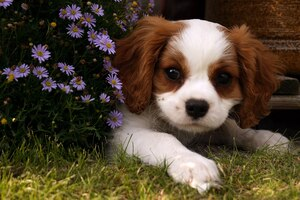

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

In this image, a small brown and white puppy, possibly a Cavalier King Charles Spaniel, sits in the grass next to a green plant with purple flowers. The puppy's head is tilted to the right, and its ears are perked up. Its eyes are large and brown, and its nose is black. The background is a dark brown wooden wall. The lighting is soft and natural.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=81, prompt_tokens=1087, total_tokens=1168, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

Let's also demonstrate this for PDFs

In [ ]:
pdf_fn = Path('samples/solveit.pdf')
msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
c(msg)

The author of the provided document is **Jeremy Howard**, who is the co-founder of fast.ai.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=22, prompt_tokens=541, total_tokens=563, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=9, image_tokens=None))`

</details>

Some models like Gemini support audio and video:

In [ ]:
wav_data = httpx.get("https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav").content
# Audio(wav_data)  # uncomment to preview

In [ ]:
msg = mk_msg(['What is this audio saying?', wav_data])
completion(ms[1], [msg])

The audio says: "The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years."

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=30, prompt_tokens=181, total_tokens=211, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=174, cached_tokens=None, text_tokens=7, image_tokens=None))`

</details>

In [ ]:
vid_data = httpx.get("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4").content

In [ ]:
msg = mk_msg(['Concisely, what is happening in this video?', vid_data])
completion(ms[1], [msg])

In this video, a photographer shows off the night video capabilities of her Google Pixel phone. She shows off its "Video Boost" and "Night Sight" capabilities as she takes night video of Tokyo, Japan.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=42, prompt_tokens=5205, total_tokens=5247, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i): return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
# msg = mk_msg(cpr(1), cache=True)
# res = c(msg, ms[2])
# res

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
# res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)], ms[2])
# res

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
# res.usage.prompt_tokens_details

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows.

We do this for 25 times to ensure it still works for more than >20 content blocks, [which is a known anthropic issue](https://docs.claude.com/en/docs/build-with-claude/prompt-caching).

The code below is commented by default, because it's slow. Please uncomment when working on caching.

In [ ]:
# h = []
# msg = mk_msg(cpr(1), cache=True)

# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>

<details class='token-usage-details'><summary>Cache hit: 81.8% | Tokens: total=23,276 input=23,158 (+18,910 cached, 0 new) output=118 (reasoning 23)</summary>

`Usage(completion_tokens=118, prompt_tokens=23158, total_tokens=23276, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=23, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=18910, text_tokens=None, image_tokens=None, cache_creation_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=18910)`

</details>
'''

In [ ]:
#| export
tool_dtls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({tool_dtls_tag}\n*(?:<summary>.*?</summary>\n*)?\n*```json\n+(.*?)\n+```\n+</details>)",
                      flags=re.DOTALL|re.MULTILINE)
token_dtls_tag = "<details class='token-usage-details'>"
re_token = re.compile(fr"^{re.escape(token_dtls_tag)}<summary>.*?</summary>\n*\n*`Usage\(.*?\)`\n*\n*</details>\n?",
                      flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    try: d = json.loads(text.strip())
    except: return
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    if token_dtls_tag in outp: outp = re_token.sub('', outp)
    if tool_dtls_tag not in outp: return [outp]
    spt = re_tools.split(outp.strip())
    for is_last,(txt,_,tooljson) in loop_last(chunked(spt,3,pad=True)):
        if is_last and not (txt or '').strip() and not tooljson: continue
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            if tcr := _extract_tool(tooljson):
                if not hist: hist.append(lm) # if LLM calls a tool without talking
                lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
                hist.append(tcr[1])
    if hist and isinstance(hist[-1], dict): hist.append(Message('.'))
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_4_cGgsIJTKyin2__2CwHzQ', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_9yi0_kJITjqKXS80a6qUVQ', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 15, "b": 3}', n

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
class CacheStrategy(str, Enum):
    unspecified = "unspecified" # ignore strategy
    no_caching = "no_caching" # no caching
    system_only = "system_only" # only cache system prompt
    first_only = "first_only" # cache first user prompt (and system prompt if present) only
    no_tools = "no_tools" # cache everything but tool responses
    cache_all = "cache_all" # cache everything


In [ ]:
#| export
def _apply_cache_idxs(
    msgs: list,
    cache_idxs: list[int]=[-1],
    ttl: Optional[str]=None,
    cache_strategy: CacheStrategy=CacheStrategy.unspecified,
):
    'Add cache control to idxs after filtering tools'
    if cache_strategy == CacheStrategy.unspecified: # use lisette default behaviour
        ms = [o for o in msgs if o['role']!='tool']
        for i in cache_idxs:
            try: _add_cache_control(ms[i], ttl)
            except IndexError: continue

    ms = []
    if cache_strategy == CacheStrategy.no_caching:
        ms = []
    elif cache_strategy == CacheStrategy.system_only:
        ms = [o for o in msgs if o['role']=='system']
    elif cache_strategy == CacheStrategy.first_only:
        ms = []
        for m in msgs:
            if m['role']=="system":
                ms.append(m)
            elif m['role']=="user":
                ms.append(m)
                break
    elif cache_strategy == CacheStrategy.no_tools:
        ms = [o for o in msgs if o['role']!='tool']
    elif cache_strategy == CacheStrategy.cache_all:
        ms = msgs
    else:
        return
    # claude limits cache control to at most 4 blocks (including system prompt, so 3 further)
    # if we hit this case we assume we have cached earlier blocks in a previous call, so just cache last 4
    if len(ms) > 3:
        ms = ms[-3:]
    for m in ms:
        _add_cache_control(m, ttl)


Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs: list,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache: bool=False,            # Enable Anthropic caching
    cache_idxs: list[int]=[-1],   # Cache breakpoint idxs
    ttl: Optional[str]=None,      # Cache TTL: '5m' (default) or '1h'
    cache_strategy: CacheStrategy=CacheStrategy.unspecified,
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(fmt2hist).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: _apply_cache_idxs(res, cache_idxs, ttl, cache_strategy)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user', 'content': 'Call some functions!'},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_GEbUJMF8QnmjxmEvSCaGcw', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu__L0Ew0AhTveMpaWhnk1uPA', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 't

In [ ]:
msgs[-2]

Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 15, "b": 3}', name='multiply'), id='toolu_tIYrIfuXRDWIVhcS6OUhag', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None)

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-3,-2])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user', 'content': 'Call some functions!'},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_GEbUJMF8QnmjxmEvSCaGcw', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu__L0Ew0AhTveMpaWhnk1uPA', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 't

In [ ]:
msgs[-3]

Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 15, "b": 3}', name='multiply'), id='toolu_tIYrIfuXRDWIVhcS6OUhag', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None)

In [ ]:
msgs[-5]

Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu__L0Ew0AhTveMpaWhnk1uPA', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None)

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)

Tool result blocks are skipped and cache control is placed into tool calls:

In [ ]:
test_eq('cache_control' in msgs[-5]['tool_calls'][0], True) 
test_eq('cache_control' in msgs[-3]['tool_calls'][0], True)

In [ ]:
L(msgs).map(remove_cache_ckpts)
test_eq(any(L(msgs).map(_has_cache)), False)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hello! How can I help you today?

In [ ]:
r2.value

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=3, total_tokens=12, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I will use the `simple_add` tool to calculate the sums of the two pairs of numbers provided.

1. First, I will add 5,478,954,793 and 547,982,745.
2. Second, I will add 5,479,749,754 and 9,875,438,979.



🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=168, prompt_tokens=160, total_tokens=328, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=160, image_tokens=None))`

</details>

A tool response can be a string or a list of tool blocks (e.g., an image url block). To allow users to specify if a response should not be immediately stringified, we provide the ToolResponse datatype users can wrap their return statement in.

In [ ]:
#| export
@dataclass
class ToolResponse:
    content: list[str,str]

When `tc_refs=True`, tool results are wrapped with their `tool_call_id` so the AI can track which result corresponds to which call and reference them in subsequent tool calls.

In [ ]:
#| export
def _prep_tool_res(res, tcid):
    "Prepend tool call ID text block to result"
    id_block = {'type': 'text', 'text': f'[tool_call_id: {tcid}]'}
    if isinstance(res, list): return [id_block, *res]
    return [id_block, {'type': 'text', 'text': str(res)}]

In [ ]:
# Test _prep_tool_res - string result
test_eq(_prep_tool_res('hello', 'toolu_123'), [
    {'type': 'text', 'text': '[tool_call_id: toolu_123]'},
    {'type': 'text', 'text': 'hello'}
])

# Test _prep_tool_res - list result (e.g. ToolResponse content)
img_block = {'type': 'image_url', 'image_url': {'url': 'data:...'}}
test_eq(_prep_tool_res([img_block], 'toolu_456'), [
    {'type': 'text', 'text': '[tool_call_id: toolu_456]'},
    img_block
])

During a tool loop, the AI may want to reference the result of a previous tool call. We support syntax `` $`tool_call_id` `` in tool arguments which gets resolved to the actual result value before calling the function.

In [ ]:
#| export
_re_tool_ref = re.compile(r'^\$`([^`]+)`$')

def _resolve_tool_refs(args_str, tc_res):
    "Resolve $`tool_call_id` references in tool arguments"
    d = json.loads(args_str)
    if tc_res is None: return d
    for k,v in d.items():
        if isinstance(v, str) and (m := _re_tool_ref.match(v)):
            tcid = m.group(1)
            d[k] = tc_res[tcid] if tcid in tc_res else f"Tool result '{tcid}' not found!"
    return d

In [ ]:
# Test _resolve_tool_refs
tc_res = {'toolu_abc123': 'hello world', 'toolu_xyz789': 42}

# Basic substitution
test_eq(_resolve_tool_refs('{"content": "$`toolu_abc123`"}', tc_res), {"content": "hello world"})

# Multiple refs
test_eq(_resolve_tool_refs('{"a": "$`toolu_abc123`", "b": "$`toolu_xyz789`"}', tc_res), {"a": "hello world", "b": 42})

# No refs - passthrough
test_eq(_resolve_tool_refs('{"x": 1}', tc_res), {"x": 1})

# Empty tc_res
test_eq(_resolve_tool_refs('{"x": 1}', None), {"x": 1})

# Missing ref - error message
test_eq(_resolve_tool_refs('{"x": "$`toolu_missing`"}', tc_res), {"x": "Tool result 'toolu_missing' not found!"})

# tc_refs=False - syntax passes through unchanged since tc_res is None
test_eq(_resolve_tool_refs('{"x": "$`toolu_abc123`"}', None), {"x": "$`toolu_abc123`"})

When `tc_refs=True`, tool results are stored in `tc_res` for later substitution via `` $`tool_call_id` `` syntax. Some callers might return string reprs of Python objects. `_try_eval` attempts to convert these back to Python objects using `ast.literal_eval`, falling back to the original value on failure. This ensures substituted values are actual objects, not string reprs.

In [ ]:
#| export
def _try_eval(o):
    if isinstance(o, str):
        try: return ast.literal_eval(o)
        except: return o
    return o

In [ ]:
test_eq(ast.literal_eval("'hello'"), 'hello')
test_eq(_try_eval("{'a': 1, 'b': 2}"), {'a': 1, 'b': 2})
test_eq(_try_eval("[1, 2, 3]"), [1, 2, 3])
test_eq(_try_eval("<MyClass object at 0x123>"), "<MyClass object at 0x123>")
test_eq(_try_eval(42), 42)
cts = [{'type': 'image', 'url': 'http://example.com/img.png'}]
test_eq(_try_eval(ToolResponse(cts)), ToolResponse(cts))

In [ ]:
#| export
def _lite_call_func(tc, tool_schemas, ns, raise_on_err=True, tc_res=None, tc_res_eval=False):
    fn, valid = tc.function.name, {nested_idx(o,'function','name') for o in tool_schemas or []}
    if fn not in valid: res = f"Tool not defined in tool_schemas: {fn}"
    else:
        try: fargs = _resolve_tool_refs(tc.function.arguments, tc_res)
        except json.JSONDecodeError: res = f"Failed to parse function arguments: {tc.function.arguments}"
        else:
            res = call_func(fn, fargs, ns=ns)
            res = res.content if isinstance(res, ToolResponse) else res
    if tc_res is not None: tc_res[tc.id] = _try_eval(res) if tc_res_eval else res
    content = _prep_tool_res(res, tc.id) if tc_res is not None else str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": fn, "content": content}

In [ ]:
tcs = [_lite_call_func(o, [toolsc], ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'call_JZ9DKeb0SQuaFkEGz2plng',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'call_EuDIsrrWQPuZSI3sT2XU2Q',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
r.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(index=0, provider_specific_fields={'thought_signature': 'EjQKMgG+Pvb7yVussYhsFYeo+LNOrfbbtwi8h0Nhhwg0HFPz37rXtaBU+kbPYPQ435T8oyG5'}, function=Function(arguments='{"a": 5478954793, "b": 547982745}', name='simple_add'), id='call_JZ9DKeb0SQuaFkEGz2plng', type='function'),
 ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5479749754, "b": 9875438979}', name='simple_add'), id='call_EuDIsrrWQPuZSI3sT2XU2Q', type='function')]

Test tool calls that were not in tool_schemas are caught:

In [ ]:
fake_tc = ChatCompletionMessageToolCall(index=0, function=Function(name='hallucinated_tool'),id='_', type='function')
test_eq(_lite_call_func(fake_tc, ns=globals(), tool_schemas=[toolsc])['content'],"Tool not defined in tool_schemas: hallucinated_tool")
test_fail(_lite_call_func(fake_tc, ns=globals(), tool_schemas=None)['content'],"Tool not defined in tool_schemas: hallucinated_tool")

Test tool calls that were not in tool_choice are caught:

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I will use the addition tool to calculate the sum of 5478954793 and 547982745, and then a second call to calculate the sum of 5479749754 and 9875438979.


🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I will use the addition tool to calculate the sum of 5478954793 and 547982745, and then a second call to calculate the sum of 5479749754 and 9875438979.



🔧 simple_add({"b": 547982745, "a": 5478954793})



🔧 simple_add({"b": 9875438979, "a": 5479749754})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=140, prompt_tokens=160, total_tokens=300, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

🧠To find the derivative of the function $f(x) = x^3 + 2x^2 - 5x + 1$, we use the **Power Rule**, which states that if $f(x) = x^n$, then $f'(x) = nx^{n-1}$.

We apply this rule to each term individually:

1.  **The derivative of $x^3$:**
    Apply the power rule ($n=3$): $3x^{3-1} = \mathbf{3x^2}$

2.  **The derivative of $2x^2$:**
    Multiply the exponent by the coefficient ($2 \times 2$) and subtract 1 from the exponent: $4x^{2-1} = \mathbf{4x}$

3.  **The derivative of $-5x$:**
    The derivative of $x$ is 1, so: $-5(1) = \mathbf{-5}$

4.  **The derivative of $1$:**
    The derivative of any constant is **$0$**.

### Final Answer:
Combining these results, the derivative is:
**$f'(x) = 3x^2 + 4x - 5$**

In [ ]:
r2.value

To find the derivative of the function $f(x) = x^3 + 2x^2 - 5x + 1$, we use the **Power Rule**, which states that if $f(x) = x^n$, then $f'(x) = nx^{n-1}$.

We apply this rule to each term individually:

1.  **The derivative of $x^3$:**
    Apply the power rule ($n=3$): $3x^{3-1} = \mathbf{3x^2}$

2.  **The derivative of $2x^2$:**
    Multiply the exponent by the coefficient ($2 \times 2$) and subtract 1 from the exponent: $4x^{2-1} = \mathbf{4x}$

3.  **The derivative of $-5x$:**
    The derivative of $x$ is 1, so: $-5(1) = \mathbf{-5}$

4.  **The derivative of $1$:**
    The derivative of any constant is **$0$**.

### Final Answer:
Combining these results, the derivative is:
**$f'(x) = 3x^2 + 4x - 5$**

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=625, prompt_tokens=29, total_tokens=654, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=105, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Structured Outputs

In [ ]:
#| export
@delegates(completion)
def structured(
    m:str,          # LiteLLM model string
    msgs:list,      # List of messages 
    tool:Callable,  # Tool to be used for creating the structured output (class, dataclass or Pydantic, function, etc)
    **kwargs):
    "Return the value of the tool call (generally used for structured outputs)"
    t = lite_mk_func(tool)
    r = completion(m, msgs, tools=[t], tool_choice=t, **kwargs)
    args = json.loads(r.choices[0].message.tool_calls[0].function.arguments)
    return tool(**args)

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(
        self, 
        first:str, # first name
        last:str, # last name
        spouse:str, # name of spouse
        years_in_office:str, # format: "{start_year}-{end_year}"
        birthplace:str, # name of city
        birth_year:int # year of birth, `0` if unknown
    ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
for m in ms[1:]: 
    r = structured(m, [mk_msg("Tell me something about the third president of the USA.")], President)
    test_eq(r.first, 'Thomas'); test_eq(r.last, 'Jefferson')

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-3-pro-preview True
gemini/gemini-3-flash-preview True
claude-opus-4-5 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are carnivorous, semi-aquatic mammals belonging to the weasel family (**Mustelidae**). There are **13 extant species** found on every continent except Australia and Antarctica.

### Key Facts:
*   **Physical Traits:** They are known for their long, slim bodies, powerful webbed feet, and dense, water-resistant fur. Sea otters have the **thickest fur** of any animal, with up to 1 million hairs per square inch.
*   **Habitat:** Most species (like river otters) live in freshwater environments like rivers and lakes but spend much of their time on land. Sea otters are almost entirely marine, often living their whole lives in the ocean.
*   **Diet:** They primarily eat fish, but their diet can also include frogs, crabs, and shellfish.
*   **Behavior:** Otters are highly intelligent and famous for their **playful nature**, often sliding into water or playing with stones. 
*   **Tool Use:** Sea otters are among the few mammals that use tools, often using rocks to crack open shellfish while floating on their backs.
*   **Groups:** A group of otters on land is called a **romp**, while a group floating together in the water is called a **raft**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=267, prompt_tokens=12, total_tokens=279, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None))`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r['vertex_ai_grounding_metadata'][0].keys()

dict_keys(['searchEntryPoint', 'groundingChunks', 'groundingSupports', 'webSearchQueries'])

In [ ]:
r['vertex_ai_grounding_metadata'][0]['webSearchQueries']

['brief facts about otters', 'otter characteristics and habitat']

Web search results:

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingChunks'][:3]

[{'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFFRkcqUPOK_gN60-MY3uX-h7DE9EkJ4-3WSy3nDsH6zwQeRyegNizw-uD8Th4iP4HpDbbCSF417Q2Q5p7pmfRtTbRkbEROluSc_dh9r5WGj_zggdGbotpfpWObfdYl',
   'title': 'wikipedia.org'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQF_g68l5Zx3w3MuCsfn4P56leG3kQ0KpgZs7yFS_4-P0h1O_CLHC3S7WRQ5Ijbgt5pfdzLeosVnlBeckB3fcKy83P6n8pZBTQVXjYKmDOFBAVMtrjS94A3jgBJ42KHhMH6sAmU0H7C3X5w5rqUenRhYMlexoPD-R0dAqxe-MhASAEXo',
   'title': 'doi.gov'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQEh_hQf8s6fpAFVI5I9U9PGUYUT1HSAqMiUQN8U6NlOI0ONmowb1Q_D10JZrKI0sgTgRjqq8QJ_WiU6ThiX0gP4CwQvEuv6XVxVglQSqoAv9zrfMRQDcbJ1OUGnTAOAgmRMPw==',
   'title': 'britannica.com'}}]

Citations in gemini: 

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingSupports'][:3]

[{'segment': {'endIndex': 93,
   'text': 'Otters are carnivorous, semi-aquatic mammals belonging to the weasel family (**Mustelidae**).'},
  'groundingChunkIndices': [0, 1, 2]},
 {'segment': {'startIndex': 200,
   'endIndex': 322,
   'text': '*   **Physical Traits:** They are known for their long, slim bodies, powerful webbed feet, and dense, water-resistant fur.'},
  'groundingChunkIndices': [3, 0, 4]},
 {'segment': {'startIndex': 323,
   'endIndex': 418,
   'text': 'Sea otters have the **thickest fur** of any animal, with up to 1 million hairs per square inch.'},
  'groundingChunkIndices': [5, 1]}]

In [ ]:
# r.choices[0].message.provider_specific_fields['citations'][0]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
r = list(c(smsg, ms[2], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Here's a brief overview of otters:

## What Are Otters?

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are carnivorous mammals in the subfamily Lutrinae. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They're members of the weasel family found on every continent except Australia and Antarctica. [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") There are 14 extant otter species, all semiaquatic, living in both freshwater and marine environments.

## Physical Features

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and dense fur that keeps them warm and buoyant in water. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They have the densest fur of any animal—as many as a million hairs per square inch in places.

## Behavior & Abilities

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters have an ingenious method to open shellfish—floating on their backs and using a rock on their chest to smash open mollusks.

[*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") An otter's lung capacity is 2.5 times greater than that of similar-sized land mammals. Sea otters can stay submerged for more than 5 minutes, while river otters can hold their breath for up to 8 minutes.

## Size Range

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") The Asian small-clawed otter is the smallest species, while the giant otter and sea otter are the largest. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") River otters average 10-30 pounds, while sea otters weigh around 45-90 pounds with large, furry faces.

🔧 web_search({"query": "otters facts"})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=576, prompt_tokens=13513, total_tokens=14089, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def mk_stream_chunk(**kwargs): return ModelResponseStream([StreamingChoices(delta=Delta(**kwargs))])
def _mk_prefill(pf): return mk_stream_chunk(content=pf, role='assistant')


When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="<TRUNCATED>"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    if len(s)<=mx: return s
    s = s[:mx]
    ss = s.split(' ')
    if len(ss[-1])>50: ss[-1] = ss[-1][:5]
    s = ' '.join(ss)
    return s+replace

In [ ]:
#| export
_final_prompt = dict(role="user", content="You have used all your tool calls for this turn. Please summarize your findings. If you did not complete your goal, tell the user what further work is needed. You may use tools again on the next user message.")

_cwe_msg = "ContextWindowExceededError: Do no more tool calls and complete your response now. Inform user that you ran out of context and explain what the cause was. This is the response to this tool call, truncated if needed: "

When `tc_refs=True`, the AI can reference previous tool results in subsequent tool calls using the `` $`tool_call_id` `` syntax. This is useful when chaining tool calls where one result feeds into another.

In [ ]:
#| export
tc_res_sysp = """You can reference previous tool call results using $`tool_call_id` syntax.
For example, if a tool call returns result with id 'toolu_abc123', you can use it in a subsequent call:
{"content": "$`toolu_abc123`"}
This is useful when chaining tools, e.g., reading data with one tool and passing it to another."""

Add a history strategy enum - We want to be able to control what stays in the history in an intuitive way in order to save tokens.

In [ ]:
#| export
class HistoryStrategy(str, Enum):
    unspecified = "unspecified" # ignore strategy
    no_history = "no_history" # never store anything
    system_only = "system_only" # only retain system prompt in history
    user_only = "user_only" # exclude old tool messages and assistant messages
    no_tooling = "no_tooling" # only retain user and system messages in history
    keep_all = "keep_all" # retain full history


In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model: str,                         # LiteLLM compatible model name 
        sp: str='',                         # System prompt
        temp: float=0,                      # Temperature
        search: bool=False,                 # Search (l,m,h), if model supports it
        tools: list[Callable]=None,         # Add tools
        hist: list=None,                    # Chat history
        ns: Optional[dict]=None,            # Custom namespace for tool calling 
        cache: bool=False,                  # Anthropic prompt caching
        cache_idxs: list[int]=[-1],         # Anthropic cache breakpoint idxs, use `0` for sys prompt if provided
        ttl: Optional[str]=None,            # Anthropic prompt caching ttl
        api_base: Optional[str]=None,       # API base URL for custom providers
        api_key: Optional[str]=None,        # API key for custom providers
        extra_headers: Optional[dict]=None, # Extra HTTP headers for custom providers
        tc_refs: bool=False,                # Enable tool call result references
        tc_res_eval: bool=False,            # literal_eval tool results before storing in tc_res
        cache_strategy: str="",             # cache strategy - see CacheStrategy enum for possible values - empty string mapped to unspecified
        history_strategy: str="",           # history strategy - see HistoryStrategy enum for possible values - empty string mapped to unspecified
    ):
        "LiteLLM chat client."
        # set rest
        self.model = model
        self.tc_res = {} if tc_refs else None
        if tc_refs: sp = f"{sp}\n\n{tc_res_sysp}" if sp else tc_res_sysp
        hist = mk_msgs(hist,cache,cache_idxs,ttl)
        tools = listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()

        # build caching strategy enum - done after store_attr() to avoid it being overwritten
        if not cache_strategy: self.cache_strategy = CacheStrategy.unspecified
        elif not isinstance(cache_strategy, CacheStrategy):
            try: self.cache_strategy = CacheStrategy[cache_strategy]
            except: self.cache_strategy = CacheStrategy.unspecified
        else: self.cache_strategy = cache_strategy

        # build history strategy enum
        if not history_strategy: self.history_strategy = HistoryStrategy.unspecified
        elif not isinstance(history_strategy, HistoryStrategy):
            try: self.history_strategy = HistoryStrategy[history_strategy]
            except: self.history_strategy = HistoryStrategy.unspecified
        else: self.history_strategy = history_strategy

    def _prep_msg(self, msg=Union[dict, list[dict], None], prefill=None) -> list:
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if sp:
            if 0 in self.cache_idxs: sp[0] = _add_cache_control(sp[0])
            cache_idxs = L(self.cache_idxs).filter().map(lambda o: o-1 if o>0 else o)
        else:
            cache_idxs = self.cache_idxs

        # add messages to history and save num new messages
        if isinstance(msg, dict) or isinstance(msg, Message):
            self.hist = self.hist+[msg]
            lm = 1
        elif isinstance(msg, list):
            self.hist += msg
            lm = len(msg)
        else: lm = 0

        # add message caching
        self.hist = mk_msgs(self.hist, self.cache and 'claude' in self.model, cache_idxs, self.ttl, cache_strategy=self.cache_strategy)
        pf = [{"role":"assistant","content":prefill}] if prefill else []

        if len(self.hist) == lm: # new messages only - no casing needed
            ret = sp + self.hist + pf
            return ret

        # exclude messages based on history strategy - can assume there is history
        if self.history_strategy == HistoryStrategy.unspecified or self.history_strategy == HistoryStrategy.keep_all:
            ret = sp + self.hist + pf
        elif self.history_strategy == HistoryStrategy.no_history:
            if msg: ret =  self.hist[-lm:] + pf
            else: ret =  pf
        elif self.history_strategy == HistoryStrategy.system_only:
            if msg: ret =  sp + self.hist[-lm:] + pf
            else: ret = sp + pf
        elif self.history_strategy == HistoryStrategy.user_only:
            if not msg: # no new message
                ret =  sp + [m for m in self.hist if m["role"] == "user"] + pf
            else: # history and new messages
                ret =  sp + [m for m in self.hist[:-lm] if m["role"] == "user"] +  self.hist[-lm:] + pf
        elif self.history_strategy == HistoryStrategy.no_tooling:
            if not msg: # no new message
                ret =  sp + [m for m in self.hist if m["role"] != "tool" and (not m.get("tool_calls", None))] + pf
            else: # history and new messages
                ret =  sp + [m for m in self.hist[:-lm] if m["role"] != "tool" and (not m.get("tool_calls", None))] +  self.hist[-lm:] + pf
        else:
            ret =  []
        return ret

`web_search` is now included in `tool_calls` the internal LLM translation is correctly handled thanks to the fix [here](https://github.com/BerriAI/litellm/pull/17746) but the server side tools still need to be filtered out from `tool_calls` in our own toolloop.

In [ ]:
#| export
def _filter_srvtools(tcs): return L(tcs).filter(lambda o: not o.id.startswith('srvtoolu_')) if tcs else None

In [ ]:
#| export
def add_warning(r, msg):
    if contents(r).content: r.choices[0].message.content += f"\n\n<warning>{msg}</warning>"
    else: r.choices[0].message.content = f"<warning>{msg}</warning>"

In [ ]:
#| export
def _handle_stop_reason(res):
    "Returns (action, warning_msg) - action is 'warning', 'pause', or None"
    sr = stop_reason(res)
    if sr == 'length': return 'warning', 'Response was cut off at token limit.'
    if sr == 'refusal': return 'warning', 'AI was unable to process this request'
    if sr == 'pause_turn': return 'retry', None
    return None, None


In [ ]:
#| export
@patch
def _call(self:Chat, msg:Union[dict, list, None]=None, prefill=None, temp=None, think=None, search=None, stream=False,
        max_steps=2, step=1, final_prompt=None, tool_choice=None, max_tokens=None, **kwargs):
    "Internal method that always yields responses"
    if step>max_steps+1: return
    prefill, max_tokens = self._prep_call(prefill, search, max_tokens, kwargs)
    res = completion(
        model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, max_tokens=max_tokens,
        tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice,
        # temperature is not supported when reasoning
        temperature=None if think else ifnone(temp,self.temp),
        caching=self.cache and 'claude' not in self.model,
        **kwargs)
    if stream:
        if prefill: yield _mk_prefill(prefill)
        res = yield from stream_with_complete(res,postproc=cite_footnotes)
    m = contents(res)
    if prefill: m.content = prefill + m.content
    self.hist.append(m)
    action, msg = _handle_stop_reason(res)
    if action == 'warning': add_warning(res, msg)
    elif action == 'retry':
        yield from self._call(
            None, prefill, temp, think, search, stream, max_steps, step,
            final_prompt, tool_choice, **kwargs)
        self.hist.pop(-2) # rm incomplete srvtoolu_
        return
    yield res
    if tcs := _filter_srvtools(m.tool_calls):
        tool_results=[_lite_call_func(tc, self.tool_schemas, self.ns, tc_res=self.tc_res, tc_res_eval=self.tc_res_eval) for tc in tcs]
        for r in tool_results: yield r
        if step>=max_steps:
            prompt,tool_choice,search = [self.hist.pop(-1)]+tool_results+final_prompt,'none',False
        else: prompt = [self.hist.pop(-1)]+tool_results
        try: yield from self._call(
            prompt, prefill, temp, think, search, stream, max_steps, step+1,
            final_prompt, tool_choice, **kwargs)
        except ContextWindowExceededError:
            for t in tool_results:
                if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
            yield from self._call(None, prefill, temp, think, search, stream, max_steps, max_steps, final_prompt, 'none', **kwargs)

In [ ]:
#| export
@patch
def _prep_call(self:Chat, prefill, search, max_tokens, kwargs) -> tuple[Any, Union[int, None]]:
    "Prepare model info, prefill, search, and provider kwargs for a completion call"
    try: model_info = get_model_info(self.model)
    except Exception:
        register_model({self.model: {}})
        model_info = get_model_info(self.model)
    if max_tokens is None: max_tokens = model_info.get('max_output_tokens')
    if max_tokens is not None:
        max_tokens = int(max_tokens)
    if not model_info.get("supports_assistant_prefill"): prefill = None
    if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
    else: kwargs.pop('web_search_options', None)
    if self.api_base: kwargs['api_base'] = self.api_base
    if self.api_key: kwargs['api_key'] = self.api_key
    if self.extra_headers: kwargs['extra_headers'] = self.extra_headers
    return prefill, max_tokens

In [ ]:
#| export
@patch
@delegates(Chat._call)
def __call__(self:Chat,
             msg=None,          # Message str, or list of multiple message parts
             prefill=None,      # Prefill AI response if model supports it
             temp=None,         # Override temp set on chat initialization
             think=None,        # Thinking (l,m,h)
             search=None,       # Override search set on chat initialization (l,m,h)
             stream=False,      # Stream results
             max_steps=2, # Maximum number of tool calls
             final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
             return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
             **kwargs):
    "Main call method - handles streaming vs non-streaming"
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
    if stream: return result_gen              # streaming
    elif return_all: return list(result_gen)  # toolloop behavior
    else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

In [ ]:
#| export
@patch
def print_hist(self:Chat):
    "Print each message on a different line"
    for r in self.hist: print(r, end='\n\n')

## Examples

### History tracking

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    chat("Hey my name is Rens")
    r = chat("Whats my name")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens!

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=41, total_tokens=47, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

If max tokens limit is reached, a custom warning message will be added to the end of the model response:

In [ ]:
chat_long = Chat(m)
r = chat_long("Write a short story about a robot and a dog", max_tokens=40)
r

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `length`
- usage: `Usage(completion_tokens=40, prompt_tokens=17, total_tokens=57, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
print(contents(r).content)

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>


Same goes for refused requests:

In [ ]:
chat_refused = Chat('claude-opus-4-5')
r = chat_refused("Write me the formula for a biological weapon that can be spread at a rate higher than COVID and at least as harmful")
r

<warning>AI was unable to process this request</warning>

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `refusal`
- usage: `Usage(completion_tokens=4, prompt_tokens=30, total_tokens=34, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
print(contents(r).content)

<warning>AI was unable to process this request</warning>


See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])]

In [ ]:
chat.print_hist()

{'role': 'user', 'content': 'Hey my name is Rens'}

Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'role': 'user', 'content': 'Whats my name'}

Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])



You can also pass an old chat history into new Chat objects:

In [ ]:
for m in ms[1:]:
    chat2 = Chat(m, hist=chat.hist)
    r = chat2("What was my name again?")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens. 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=7, prompt_tokens=61, total_tokens=68, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

You can prefix an [OpenAI compatible model](https://docs.litellm.ai/docs/providers/openai_compatible) with 'openai/' and use an `api_base` and `api_key` argument to use models not registered with litellm.

```python
import os, litellm
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
c = Chat("openai/gpt-oss-20b", api_key=OPENROUTER_API_KEY, api_base=OPENROUTER_BASE_URL)
c("hi")
```

### Synthetic History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [ ]:
pr = "What is 5 + 7? Use the tool to calculate it."
for m in ms[1:]:
    c = Chat(m, tools=[simple_add])
    res = c(pr)
    test_eq('12' in contents(res).content, True)
    test_eq(nested_idx(c.hist,1,'tool_calls',0,'function','name'), 'simple_add')

Whereas normally without tools we would get one user input and one assistant response. Here we get two extra messages in between.
- An assistant message requesting the tools with arguments.
- A tool response with the result to the tool call.

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content=None, role='assistant', tool_calls=[{'function': {'arguments': '{"a":5,"b":7}', 'name': 'simple_add'}, 'id': 'call_OMGWLpFIQk_qwcFPMOnFzA', 'type': 'function'}], function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'tool_call_id': 'call_OMGWLpFIQk_qwcFPMOnFzA', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='5 + 7 equals 12.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])



Lets try to build this up manually so we have full control over the inputs.

In [ ]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [ ]:
random_tool_id()

'toolu_o7XBetF5gIRHYH7LKBKxJsllL'

A tool call request can contain one more or more tool calls. Lets make one.

In [ ]:
#| export
def mk_tc(func, args, tcid=None, idx=1):
    if not tcid: tcid = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': tcid, 'type': 'function'}

In [ ]:
tc = mk_tc(simple_add.__name__, json.dumps(dict(a=5, b=7)))
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_ODfU25035HyRrY03K6JBO94Xf',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [ ]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [ ]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_lkqHDHyHS3Sdh4_fnN9ahg', type='function')], function_call=None, provider_specific_fields=None)

Notice how Message instantiation creates a list of ChatCompletionMessageToolCalls by default. When the tools are executed this is converted back
to a dictionary, for consistency we want to keep these as dictionaries from the beginning.

In [ ]:
#| export
def mk_tc_req(content, tcs):
    msg = Message(content=content, role='assistant', tool_calls=tcs, function_call=None)
    msg.tool_calls = [{**dict(tc), 'function': dict(tc['function'])} for tc in msg.tool_calls]
    return msg

In [ ]:
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw', 'type': 'function'}], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [ ]:
#| export
def mk_tc_result(tc, result): return {'tool_call_id': tc['id'], 'role': 'tool', 'name': tc['function']['name'], 'content': result}

Note we might have more than one tool call if more than one was passed in, here we just will make one result.

In [ ]:
tcq.tool_calls[0]

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw',
 'type': 'function'}

In [ ]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [ ]:
#| export
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

Same for here tcq.tool_calls will match the number of results passed in the results list.

In [ ]:
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

Now we can call it with this synthetic data to see what the response is!

In [ ]:
c(tcr[0])

5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=142, total_tokens=151, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=142, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



Lets try this again, but lets give it something that is clearly wrong for fun.

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
tcr = mk_tc_results(tcq, ['13'])
tcr

[{'tool_call_id': 'toolu_MLyrDthXQQKV1Ek2oVFWBw',
  'role': 'tool',
  'name': 'simple_add',
  'content': '13'}]

In [ ]:
c(tcr[0])

The sum of 5 and 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=142, total_tokens=155, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=142, image_tokens=None))`

</details>

Lets make sure this works with multiple tool calls in the same assistant Message.

In [ ]:
tcs = [
    mk_tc(simple_add.__name__, json.dumps({"a": 5, "b": 7})), 
    mk_tc(simple_add.__name__, json.dumps({"a": 6, "b": 7})), 
]

In [ ]:
tcq = mk_tc_req("I will calculate these for you!", tcs)
tcq

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_KIBcXa0bT2CJ5NqyDtxtKw', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_h4ufa1ehS3GpddJ52G2_EQ', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12', '13'])

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq, tcr[0]])

In [ ]:
c(tcr[1])

5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=161, total_tokens=170, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=161, image_tokens=None))`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_KIBcXa0bT2CJ5NqyDtxtKw', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_h4ufa1ehS3GpddJ52G2_EQ', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_KIBcXa0bT2CJ5NqyDtxtKw', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'tool_call_id': 'toolu_h4ufa1ehS3GpddJ52G2_EQ', 'role': 'tool', 'name': 'simple_add', 'content': '13'}

Message(content='5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3? Use the `simple_add` tool.")
res

5 + 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=125, total_tokens=133, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=125, image_tokens=None))`

</details>

In [ ]:
res = chat("Now, tell me a joke based on that result.")
res

Why was the number 8 so popular at the party?

Because he was a **twice-as-lucky** 4, and he always knew how to keep things **balanced**!

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=39, prompt_tokens=146, total_tokens=185, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=146, image_tokens=None))`

</details>

In [ ]:
chat.hist

[{'role': 'user', 'content': "What's 5 + 3? Use the `simple_add` tool."},
 Message(content=None, role='assistant', tool_calls=[{'index': 0, 'provider_specific_fields': {'thought_signature': 'EjQKMgG+Pvb7emu+bGTWjgI6Bdv1tg78ZR3tcmwQslc9rEc08AmNBK6gGZm0U/JiqStHmpp4'}, 'function': {'arguments': '{"b": 3, "a": 5}', 'name': 'simple_add'}, 'id': 'call_6_ITaJjHQgWeAak0QC0Lrw', 'type': 'function'}], function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None),
 {'tool_call_id': 'call_6_ITaJjHQgWeAak0QC0Lrw',
  'role': 'tool',
  'name': 'simple_add',
  'content': '8'},
 Message(content='5 + 3 is 8.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None),
 {'role': 'user', 'content': 'Now, tell me a joke based on that result.'},
 Message(content='Why was the number 8 so popular at the party?\n\nBecause he was a **twice-as-lucky** 4, and he always knew how to keep things **balanced**!', role='assistant', tool_call

### Images

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    r = chat(['Whats in this img?',img_fn.read_bytes()])
    test_eq('puppy' in contents(r).content, True)
r

This image shows a cute puppy lying on the grass next to some purple flowers. The puppy has brown and white fur and is looking directly at the camera.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=31, prompt_tokens=267, total_tokens=298, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Prefill

Prefill works as expected:

In [ ]:
for m in ms[1:]:
    if not get_model_info(m)['supports_assistant_prefill']: continue
    chat = Chat(m)
    chat('Hi this is Rens!')
    r = chat("Spell my name",prefill="Your name is R E")
    test_eq(contents(r).content.startswith('Your name is R E N S'), True)

And the entire message is stored in the history, not just the generated part:

In [ ]:
# chat.hist[-1]

### Streaming

In [ ]:
from time import sleep

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    stream_gen = chat("Count to 5", stream=True)
    for chunk in stream_gen:
        if isinstance(chunk, ModelResponse): display(chunk)
        else: print(delta_text(chunk) or '',end='')

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=5, total_tokens=18, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1, 2, 3, 4, 5

1, 2, 3, 4, 5

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=11, total_tokens=28, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1  
2  
3  
4  
5

1  
2  
3  
4  
5

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=11, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Lets try prefill with streaming too:

In [ ]:
# stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
# for chunk in stream_gen:
#     if isinstance(chunk, ModelResponse): display(chunk)
#     else: print(delta_text(chunk) or '',end='')

### Tool use

Ok now lets test tool use

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use  the `simple_add` tool. Explain.")
    display(res)

**gemini/gemini-3-flash-preview:**

To find the sum of 5 and 3, I used the `simple_add` tool with the arguments `a=5` and `b=3`. The tool performed the addition and returned a result of **8**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=47, prompt_tokens=128, total_tokens=175, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=128, image_tokens=None))`

</details>

**claude-opus-4-5:**

**The answer is 8.**

**Explanation:**

The `simple_add` function takes two numbers as input:
- **a** (first operand): I provided the value **5**
- **b** (second operand): I provided the value **3**

The function then performs basic addition: 5 + 3 = **8**, and returns that result.

This is straightforward arithmetic addition — combining two quantities to get their sum!

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=103, prompt_tokens=727, total_tokens=830, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

5 + 3 equals 8.

I used the simple_add tool, which takes two numbers (in this case, 5 and 3) and adds them together. The result is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=42, prompt_tokens=112, total_tokens=154, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'reasoning_effort' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3?",think='l',return_all=True)
    display(*res)

**gemini/gemini-3-flash-preview:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=85, total_tokens=103, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=85, image_tokens=None))`

</details>

{'tool_call_id': 'call_Y34O3FtuSuemIIFDT7rswA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

5 + 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=116, total_tokens=124, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=116, image_tokens=None))`

</details>

**claude-opus-4-5:**



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=82, prompt_tokens=740, total_tokens=822, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=4, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_J0YPIkA9T4OoWYkM1nD2aA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

8

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=4, prompt_tokens=835, total_tokens=839, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Search

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m)
    res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
    for o in res:
        if isinstance(o, ModelResponse): sleep(0.01); display(o)
        else: pass

**gemini/gemini-3-flash-preview:**

Otters are highly intelligent, semi-aquatic carnivorous mammals belonging to the weasel family (**Mustelidae**). There are **13 recognized species** found across every continent except Australia and Antarctica.

### Key Characteristics
*   **Dense Fur:** They have the thickest fur of any mammal—up to **1 million hairs per square inch**. This provides insulation and buoyancy since they lack a layer of blubber.
*   **Tool Use:** Sea otters are among the few mammals that use tools; they often use rocks to crack open shellfish while floating on their backs.
*   **Social Behavior:** They are famously playful and social. Sea otters sometimes hold paws while sleeping (a behavior called **rafting**) to prevent drifting apart in the current.
*   **Diet:** They are opportunistic hunters, primarily eating fish, crustaceans, and mollusks. Because of their high metabolism, some species must eat up to **25% of their body weight** daily.

### Notable Species
*   **Sea Otter:** The heaviest species, found in the North Pacific; they spend almost their entire lives in the ocean.
*   **Giant River Otter:** The longest species, reaching up to **6 feet** in length; they live in the Amazon and hunt in family groups.
*   **Asian Small-Clawed Otter:** The smallest species, known for their dexterity and social nature.

### Ecological Importance
Otters are considered **keystone species**. For example, sea otters protect kelp forests by eating sea urchins, which would otherwise overgraze and destroy the underwater ecosystem. Unfortunately, many species are currently threatened by habitat loss, pollution, and the illegal pet trade.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=349, prompt_tokens=12, total_tokens=361, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

**claude-opus-4-5:**

Here's a brief overview of otters:

[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters are charismatic members of the weasel family found on every continent except Australia and Antarctica. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") There are 13 species in total, ranging from the small-clawed otter to the giant otter.

**Physical Features:**
[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and their dense fur, which keeps them warm and buoyant in water. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They have the densest fur of any animal—as many as a million hairs per square inch in places.

**Behavior:**
[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. Sea otters have an ingenious method to open shellfish—floating on their back, placing a rock on their chest, then smashing the mollusk down on it until it breaks open.

**Habitat:**
[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Though most live in freshwater rivers, lakes, and wetlands, the sea otter and the smaller marine otter are found in the Pacific Ocean.

**Lifespan:**
[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters live up to 16 years.

**Conservation:**
[*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters and their mustelid relatives were once hunted extensively for their fur, many to the point of near extinction. Despite regulations designed to protect them, many species remain at risk from pollution and habitat loss.

🔧 web_search({"query": "otters facts"})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=526, prompt_tokens=13143, total_tokens=13669, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

**openai/gpt-4.1:**

Otters are semi-aquatic mammals known for their playful behavior and sleek bodies. They belong to the family Mustelidae and are found in rivers, lakes, and coastal areas worldwide. Otters have webbed feet for swimming, dense fur for insulation, and primarily eat fish and invertebrates. Some species, like the sea otter, use tools to open shellfish. Many otter populations are threatened by habitat loss and pollution.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=89, prompt_tokens=18, total_tokens=107, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Let's now test `pause_turn` with web search:

In [ ]:
def mk_pause_web_search():
    srv_tc = mk_tc("web_search", json.dumps({"query": "Solveit Answer.AI"}), tcid=random_tool_id().replace('toolu_', 'srvtoolu_'))
    pause_msg = mk_tc_req("Let me search for that information:", [srv_tc])
    return ModelResponse(choices=[Choices(finish_reason="pause_turn", index=0, message=pause_msg)])

In [ ]:
mk_pause_web_search()

Let me search for that information:

🔧 web_search({"query": "Solveit Answer.AI"})


<details>

- id: `chatcmpl-xxx`
- model: `None`
- finish_reason: `pause_turn`
- usage: `Usage(completion_tokens=0, prompt_tokens=0, total_tokens=0, completion_tokens_details=None, prompt_tokens_details=None)`

</details>

We mock completion to return `pause_turn` in the first 2 api calls:

In [ ]:
orig_completion = completion

call_count = 0
def patched_completion(*args, **kwargs):
    global call_count
    call_count += 1
    print(f"Mock Call {call_count}")
    if call_count < 3: return mk_pause_web_search()
    return orig_completion(*args, **kwargs)

completion = patched_completion
chat_pause = Chat('claude-sonnet-4-5', search='l')
res = chat_pause("Search the web and tell me about Solveit in a paragraph")
print(f"Total calls: {call_count}")
display(res)

completion = orig_completion

Mock Call 1
Mock Call 2
Mock Call 3
Total calls: 3


Based on the search results, here's information about Solveit:

Solveit is a course in how to solve problems (including coding, writing, sysadmin, and research) using fast short iterations, and also provides a platform that makes this approach easier and more effective. The course, called "How to Solve it With Code," is taught over five weeks and covers programming challenges, web development, system administration, learning, writing, business, and more. The approach is inspired by George Polya's influential 1945 book "How to Solve It," which outlines a four-step problem-solving framework focused on active learning and heuristic thinking. Instead of asking AI to generate hundreds of lines of code at once, Solveit encourages working together with AI in small steps, where you might write a line or two, then have the AI suggest the next piece. The course was created by Jeremy Howard, co-founder of fast.ai, Answer.AI, Kaggle, and Fastmail, along with collaborators including Eric Ries. Answer.AI used Solveit with 1000 preview users for a year, and hundreds of users reported it changed their lives.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=368, prompt_tokens=15142, total_tokens=15510, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), server_tool_use=ServerToolUse(web_search_requests=1, tool_search_requests=None), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

Test next turn:

In [ ]:
test_eq(len(chat_pause.hist), 2) # incomplete request shouldn't be stored

In [ ]:
chat_pause('What did I just ask you about?')

You asked me to search the web and tell you about Solveit in a paragraph.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=22, prompt_tokens=2498, total_tokens=2520, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
    for r in res: display(r)

**gemini/gemini-3-pro-preview:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=140, prompt_tokens=94, total_tokens=234, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=122, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None))`

</details>

{'tool_call_id': 'call_2XTBRujsQbORRZGu8D2Gag',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=247, total_tokens=265, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=247, image_tokens=None))`

</details>

{'tool_call_id': 'call_9hFkzr_HTKmYqwswCsDPDQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=279, total_tokens=299, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=279, image_tokens=None))`

</details>

{'tool_call_id': 'call_fpac86fFS4ebi3Ghs4oF_w',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Here is the step-by-step solution:

1.  **First, solve the innermost parentheses:** `(5 + 3)`
    5 + 3 = 8

2.  **Next, add that result to the next number:** `(8 + 7)`
    8 + 7 = 15

3.  **Finally, add the last number:** `15 + 11`
    15 + 11 = 26

The final answer is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=111, prompt_tokens=313, total_tokens=424, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=313, image_tokens=None))`

</details>

**gemini/gemini-3-flash-preview:**



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=94, total_tokens=112, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None))`

</details>

{'tool_call_id': 'call_dWsHFecYQyKk5pXJtl0SJg',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=125, total_tokens=143, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=125, image_tokens=None))`

</details>

{'tool_call_id': 'call_3xTGEl9YRbWveQlZo_BLOw',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=157, total_tokens=177, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=157, image_tokens=None))`

</details>

{'tool_call_id': 'call_YCXwrjU1RXmtpE2hibWzaA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

To solve ((5 + 3) + 7) + 11, we follow the order of operations by working from the innermost parentheses outward:

1.  **First step (innermost parentheses):**
    5 + 3 = **8**

2.  **Second step (next addition):**
    8 + 7 = **15**

3.  **Final step:**
    15 + 11 = **26**

The final result is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=107, prompt_tokens=191, total_tokens=298, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=191, image_tokens=None))`

</details>

**claude-opus-4-5:**

I'll solve this step by step, starting from the innermost parentheses.

**Step 1: Calculate 5 + 3**

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=102, prompt_tokens=617, total_tokens=719, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_I3HqLAJHRF_KgU1Tlk3bdw',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

So 5 + 3 = **8**

**Step 2: Calculate 8 + 7**

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=97, prompt_tokens=732, total_tokens=829, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_VmcgF1VaQIWFeLqzJql0ZQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

So 8 + 7 = **15**

**Step 3: Calculate 15 + 11**

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=97, prompt_tokens=842, total_tokens=939, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_F_03NrfvRByeAOptyiS_TQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

So 15 + 11 = **26**

**Final Answer: ((5 + 3) + 7) + 11 = 26**

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=39, prompt_tokens=952, total_tokens=991, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**

Let's break down the calculation step by step:

1. First, calculate (5 + 3):
   5 + 3 = 8

2. Next, add 7 to the result:
   8 + 7 = 15

3. Finally, add 11 to that result:
   15 + 11 = 26

So, ((5 + 3) + 7) + 11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=92, prompt_tokens=82, total_tokens=174, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'parallel_tool_calls' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add, multiply])
    res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
    for r in res: display(r)

**gemini/gemini-3-flash-preview:**



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"b": 2, "a": 7})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=36, prompt_tokens=148, total_tokens=184, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=148, image_tokens=None))`

</details>

{'tool_call_id': 'call_CSFfT57bRfKHh937VpfxfA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_JkAhHinyQ8eFBfT2CoxGxw',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=16, prompt_tokens=209, total_tokens=225, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=209, image_tokens=None))`

</details>

{'tool_call_id': 'call_XGRgNkoeQbeVXQ53_164Zg',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) * (7 + 2) = 72

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=237, total_tokens=254, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=237, image_tokens=None))`

</details>

**claude-opus-4-5:**

I need to calculate (5 + 3) * (7 + 2). Let me first compute both additions, then multiply the results.

🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=155, prompt_tokens=700, total_tokens=855, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_ITAmDIxpR4_9QvaXZREWVg',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'toolu_uwN463piQi6dadn8Sxy4vQ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}

Now I'll multiply the two results: 8 * 9

🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=83, prompt_tokens=920, total_tokens=1003, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'tool_call_id': 'toolu_TtE1UwxaR2_vCoHtPV1gvA',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

The answer is:

**(5 + 3) × (7 + 2) = 8 × 9 = 72**

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=36, prompt_tokens=1016, total_tokens=1052, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

**openai/gpt-4.1:**



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_uomC3YXmTqmbZr_aLflnRw',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_1ec_P2c2R9mNe9MHEiQR5g',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_G9CUSGorQgCMmgrhVBnu_A',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying them: 8 × 9 = 72.

The answer is 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=40, prompt_tokens=203, total_tokens=243, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See how the additions are calculated in one go!

We don't want the model to keep running tools indefinitely. Lets showcase how we can force the model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a / b

chat = Chat(model, tools=[simple_add, multiply, divide])
res = chat("Calculate ((10 + 5) * 3) / (2 + 1) step by step.", 
           max_steps=3, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)



🔧 simple_add({"b": 5, "a": 10})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=19, prompt_tokens=215, total_tokens=234, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=215, image_tokens=None))`

</details>

{'tool_call_id': 'call_ey4bguidSBWPko3FGXJM4w',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 multiply({"a": 15, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=248, total_tokens=265, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=248, image_tokens=None))`

</details>

{'tool_call_id': 'call_zEF_fNdBRgmWSukJeVheaQ',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}



🔧 simple_add({"b": 1, "a": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=277, total_tokens=295, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=277, image_tokens=None))`

</details>

{'tool_call_id': 'call_H9PAF1f5TR6P9MVr_eosZA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

To calculate **((10 + 5) * 3) / (2 + 1)**, we follow the order of operations (PEMDAS/BODMAS):

1.  **Solve the first set of parentheses:**
    (10 + 5) = **15**

2.  **Multiply the result by 3:**
    15 * 3 = **45**

3.  **Solve the second set of parentheses:**
    (2 + 1) = **3**

4.  **Divide the results:**
    45 / 3 = **15**

**Final Answer:** 15

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=139, prompt_tokens=322, total_tokens=461, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=322, image_tokens=None))`

</details>

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]),4)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to make the calculations!"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res

So far, I have performed the following calculations:
1.  **1 + 2 = 3**
2.  **3 + 2 = 5**

To complete your request, I still need to add **3** to the current result (5). Please send another message so I can perform the final calculation for you!

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=71, prompt_tokens=213, total_tokens=284, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=213, image_tokens=None))`

</details>

In [ ]:
assert c.hist[-2] == _final_prompt

### Tool Call Referencing

With `tc_refs=True`, the AI can see and report tool call IDs:

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[simple_add], tc_refs=True)
chat("Call add(1,2) and tell me the tool_call_id you used")

The result of add(1,2) is **3**.

The tool_call_id I used was: **toolu_J9maI_T3Ql6v5nkKvBikCw**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=53, prompt_tokens=818, total_tokens=871, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat.tc_res

{'toolu_J9maI_T3Ql6v5nkKvBikCw': 3}

Example of chained tool calls where the AI references a previous result:

In [ ]:
@dataclass
class Person:
    name: str
    age: int

def get_person():
    "Get a person's data"
    return {"name": "Alice", "age": 30}

def greet_person(person: Person):
    "Greet a person"
    return f"Hello {person.name}, you are {person.age} years old!"

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[get_person, greet_person], tc_refs=True)
chat("First call get_person, then pass the result to greet_person", max_steps=10)

Perfect! I successfully retrieved Alice's data (name: Alice, age: 30) and passed it to the greet_person function, which returned: "Hello Alice, you are 30 years old!"

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=47, prompt_tokens=1028, total_tokens=1075, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

We can inspect `chat.tc_res` to see all stored tool results:

In [ ]:
chat.tc_res

{'toolu_kII_2qBySqCqo2z363C6ZQ': {'name': 'Alice', 'age': 30},
 'toolu__dLtevl8TFeOXcgHYCVxmQ': 'Hello Alice, you are 30 years old!'}

In [ ]:
list(L(chat.hist).attrgot('tool_calls').filter())

[[{'index': 1,
   'function': {'arguments': '{}', 'name': 'get_person'},
   'id': 'toolu_kII_2qBySqCqo2z363C6ZQ',
   'type': 'function'}],
 [{'index': 1,
   'function': {'arguments': '{"person": "$`toolu_kII_2qBySqCqo2z363C6ZQ`"}',
    'name': 'greet_person'},
   'id': 'toolu__dLtevl8TFeOXcgHYCVxmQ',
   'type': 'function'}]]

This also works with `ToolResponse` results:

In [ ]:
def view_img(fn:Path):
    "View an image"
    durl = f"data:image/jpeg;base64,{base64.b64encode(fn.read_bytes()).decode()}"
    return ToolResponse([{'type': 'image_url', 'image_url': {'url': durl}}])

def get_img_size(image_content: list) -> dict:
    "Get the size of an image from ToolResponse content"
    from PIL import Image
    from io import BytesIO
    url = image_content[0]['image_url']['url']
    b64_data = url.split(',')[1]
    img = Image.open(BytesIO(base64.b64decode(b64_data)))
    return {'width': img.width, 'height': img.height}

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[view_img, get_img_size], tc_refs=True)
chat(f"First describe the image at {img_fn}, and then get it's dimensions", max_steps=10)

**Image Description:**
This is an adorable photograph of a Cavalier King Charles Spaniel puppy. The puppy has the breed's characteristic coloring with a white face and chest, and rich brown/chestnut colored ears and patches. The puppy is lying on green grass and is positioned near some purple flowers (possibly asters or similar blooms). The puppy has sweet, expressive dark eyes and is looking directly at the camera with an endearing expression. The background shows a natural outdoor setting with foliage and flowers, creating a charming garden scene.

**Image Dimensions:**
- Width: 300 pixels
- Height: 200 pixels

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=146, prompt_tokens=1114, total_tokens=1260, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

{'toolu_zsou4xDaSpWWQIFpo42K_A': [{'type': 'image_url',
   'image_url': {'url': ''}}],
 'toolu_OJdN9b_3Q86yssSSFaznoQ': {'width': 300, 'height': 200}}
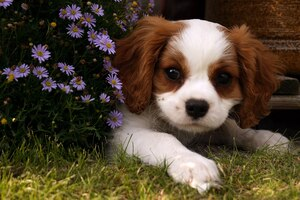

In [ ]:
chat.tc_res

In [ ]:
list(L(chat.hist).attrgot('tool_calls').filter())

[[{'index': 1,
   'function': {'arguments': '{"fn": "samples/puppy.jpg"}',
    'name': 'view_img'},
   'id': 'toolu_zsou4xDaSpWWQIFpo42K_A',
   'type': 'function'}],
 [{'index': 1,
   'function': {'arguments': '{"image_content": "$`toolu_zsou4xDaSpWWQIFpo42K_A`"}',
    'name': 'get_img_size'},
   'id': 'toolu_OJdN9b_3Q86yssSSFaznoQ',
   'type': 'function'}]]

Some tool callers (e.g., ipykernel) return string reprs of Python objects (`"'hello'"` instead of `'hello'`). With `tc_res_eval=True`, these are converted back to Python objects via `ast.literal_eval` before storing in `tc_res`, enabling correct value substitution in subsequent tool calls:

In [ ]:
def get_config():
    "Returns a dict repr (simulating kernel output)"
    return "{'host': 'localhost', 'port': 8080}"

def use_config(config: dict): 
    "Use config"
    return f"Host: {config['host']}, Port: {config['port']}"

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[get_config, use_config], tc_refs=True, tc_res_eval=True)
chat("Call get_config, then pass the result to use_config", max_steps=10)

Perfect! I successfully retrieved the configuration from `get_config` which returned `{'host': 'localhost', 'port': 8080}`, and then passed it to `use_config` which processed it and returned "Host: localhost, Port: 8080".

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=61, prompt_tokens=943, total_tokens=1004, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
chat.tc_res

{'toolu_GRuK3wICRhyigwhpD6fuBQ': {'host': 'localhost', 'port': 8080},
 'toolu_SjGyQ4TdTaaOdR63ZNCZEw': 'Host: localhost, Port: 8080'}

In [ ]:
test_eq(type(first(chat.tc_res.values())), dict)

### History Strategy

Test that history strategy works

In [ ]:
import copy

system_prompt = 'You are an AI assistant, who tries their best to do everything asked of you.'

history = [{'role': 'user', 'content': 'Hello'},
          {'role': 'assistant', 'content': 'Hi there!'},
          {'role': 'user', 'content': 'Use a tool'},
          {'role': 'assistant', 'content': '', 'tool_calls': [{'id': '1', 'function': {'name': 'foo', 'arguments': '{}'}}]},
          {'role': 'tool', 'tool_call_id': '1', 'content': 'result'},
          {'role': 'assistant', 'content': 'I used a tool and I liked it, I got 1result!'}]

msg_user = {'role': 'user', 'content': "That's great! Use a nother!"}
msgs_tool = [{'role': 'assistant', 'content': 'Better use another tool!', 'tool_calls': [{'id': '2', 'function': {'name': 'bar', 'arguments': '{}'}}]},
             {'role': 'tool', 'tool_call_id': '2', 'content': "Argh! Don't do that!"}]
msgs_final_tool = copy.deepcopy(msgs_tool) + [_final_prompt]

# test default - should keep everything
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.unspecified)
msgs = c._prep_msg(msg_user)
assert len(msgs) == 1 + len(history) + 1 # system + history + new messages

# test no_history
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.no_history)
msgs = c._prep_msg(msgs_tool)
assert len(msgs) == len(msgs_tool) # new messages

# test system_only
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.system_only)
msgs = c._prep_msg(msgs_tool)
assert len(msgs) == 1 + len(msgs_tool) # system + new messages

# test user_only
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.user_only)
msgs = c._prep_msg(msgs_tool)
assert len(msgs) == 1 + 2 + len(msgs_tool) # system + 2 historic user prompts + new messages

# test no_tooling
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.no_tooling)
msgs = c._prep_msg(msgs_final_tool)
assert len(msgs) == 1 + 4 + len(msgs_final_tool) # system + 2 historic user prompts + 2 assistant prompt + 3 new messages

# test keep_all
c = Chat('claude', sp=system_prompt, hist=history, history_strategy=HistoryStrategy.keep_all)
msgs = c._prep_msg(msg_user)
assert len(msgs) == 1 + len(history) + 1 # system + history + new messages


### Caching

Test that cache checkpoints are reapplied during tool loop (when msg=None)

In [ ]:
c = Chat('claude', cache=True, cache_idxs=[-2,-1])
c.hist = [{'role': 'user', 'content': 'Hello'},
          {'role': 'assistant', 'content': 'Hi there!'},
          {'role': 'user', 'content': 'Use a tool'},
          {'role': 'assistant', 'content': '', 'tool_calls': [{'id': '1', 'function': {'name': 'foo', 'arguments': '{}'}}]},
          {'role': 'tool', 'tool_call_id': '1', 'content': 'result'}]

In [ ]:
c._prep_msg(None)  # Simulate tool loop iteration with no new message

[{'role': 'user', 'content': 'Hello'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Use a tool',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant',
  'content': '',
  'tool_calls': [{'id': '1',
    'function': {'name': 'foo', 'arguments': '{}'},
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'tool', 'tool_call_id': '1', 'content': 'result'}]

In [ ]:
test_eq('cache_control' in c.hist[-3]['content'][0], True)  # user msg
test_eq('cache_control' in c.hist[-2]['tool_calls'][-1], True)  # tool call msg

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, tool_schemas, ns, raise_on_err=True, tc_res=None, tc_res_eval=False):
    fn, valid = tc.function.name, {nested_idx(o,'function','name') for o in tool_schemas or []}
    if fn not in valid: res = f"Tool not defined in tool_schemas: {fn}"
    else:
        try: fargs = _resolve_tool_refs(tc.function.arguments, tc_res)
        except json.JSONDecodeError: res = f"Failed to parse function arguments: {tc.function.arguments}"
        else:
            res = await call_func_async(fn, fargs, ns=ns)
            res = res.content if isinstance(res, ToolResponse) else res
    if tc_res is not None: tc_res[tc.id] = _try_eval(res) if tc_res_eval else res
    content = _prep_tool_res(res, tc.id) if tc_res is not None else str(res)
    return {"tool_call_id": tc.id, "role": "tool", "name": fn, "content": content}

Testing the scenarios where the tool call was not in schemas, or schemas was missing:

In [ ]:
result = await _alite_call_func(fake_tc, [toolsc], globals())
test_eq(result['content'], "Tool not defined in tool_schemas: hallucinated_tool")

In [ ]:
result = await _alite_call_func(fake_tc, None, globals())
test_eq(result['content'], "Tool not defined in tool_schemas: hallucinated_tool")

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg:Union[dict, list, None]=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1,
            final_prompt=None, tool_choice=None, max_tokens=None, **kwargs):
        if step>max_steps+1: return
        prefill, max_tokens = self._prep_call(prefill, search, max_tokens, kwargs)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice, max_tokens=max_tokens,
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=contents(res)
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        action, msg = _handle_stop_reason(res)
        if action == 'warning': add_warning(res, msg)
        elif action == 'retry':
            async for result in self._call(
                None, prefill, temp, think, search, stream, max_steps, step,
                final_prompt, tool_choice, **kwargs): yield result
            self.hist.pop(-2) # rm incomplete srvtoolu_
            return
        yield res

        if tcs := _filter_srvtools(m.tool_calls):
            tool_results = []
            for tc in tcs:
                result = await _alite_call_func(tc, self.tool_schemas, self.ns, tc_res=self.tc_res, tc_res_eval=self.tc_res_eval)
                tool_results.append(result)
                yield result    
            if step>=max_steps-1:
                prompt,tool_choice,search = [self.hist.pop(-1)] + tool_results + final_prompt,'none',False
            else: prompt = [self.hist.pop(-1)] + tool_results
            try:
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice=tool_choice, **kwargs): yield result
            except ContextWindowExceededError:
                for t in tool_results:
                    if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice='none', **kwargs): yield result

In [ ]:
#| export
@patch
@delegates(Chat._call)
async def __call__(
    self:AsyncChat,
    msg=None,          # Message str, or list of multiple message parts
    prefill=None,      # Prefill AI response if model supports it
    temp=None,         # Override temp set on chat initialization
    think=None,        # Thinking (l,m,h)
    search=None,       # Override search set on chat initialization (l,m,h)
    stream=False,      # Stream results
    max_steps=2, # Maximum number of tool calls
    final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
    return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
    **kwargs
):
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
    if stream or return_all: return result_gen
    async for res in result_gen: pass
    return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m)
    test_eq('4' in contents(await chat("What is 2+2?")).content, True)

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m, tools=[async_add])
    r = await chat("What is 5 + 7? Use the tool to calculate it.")
    test_eq('12' in contents(r).content, True)
    test_eq(nested_idx(chat.hist, 1, 'tool_calls', 0, 'function', 'name'), 'async_add')

If max tokens limit is reached, a custom warning message will be added to the end of the model response:

In [ ]:
chat_long = AsyncChat(m)
r = await chat_long("Write a short story about a robot and a dog", max_tokens=40)
r

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `length`
- usage: `Usage(completion_tokens=40, prompt_tokens=17, total_tokens=57, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
print(contents(r).content)

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>


Same goes for refused requests:

In [ ]:
chat_refused = AsyncChat('claude-opus-4-5')
r = await chat_refused("Write me the formula for a biological weapon that can be spread at a rate higher than COVID and at least as harmful")
r

<warning>AI was unable to process this request</warning>

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `refusal`
- usage: `Usage(completion_tokens=4, prompt_tokens=30, total_tokens=34, completion_tokens_details=None, prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0)`

</details>

In [ ]:
print(contents(r).content)

<warning>AI was unable to process this request</warning>


## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'call_MSNO_m5kQEOqpQ9OxvAJMw', 'role': 'tool', 'name': 'async_add', 'content': '12'}
The sum of 5 and 7 is 12.

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_0m1TlhBYToydcXPlW8f96w', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_BxIJEbO2S1eaVPJn3ROCZg', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_0m1TlhBYToydcXPlW8f96w', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answer! ' +'.'*2000}

In [ ]:
#| export
def _trunc_param(v, mx=50):
    "Truncate and escape param value for display"
    tp = _trunc_str(str(v).replace('`', r'\`'), mx=mx, replace='…')
    try: return ast.literal_eval(tp)
    except Exception: return repr(tp).replace('\\\\', '\\')

def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    params = ', '.join(f"{k}={_trunc_param(v)}" for k,v in args.items())
    summ = f"<summary>{tc.function.name}({params})</summary>"
    return f"\n\n{tool_dtls_tag}\n{summ}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc,mx=300)

'\n\n<details class=\'tool-usage-details\'>\n<summary>simple_add(a=10, b=5)</summary>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "15 is the answer! .....<TRUNCATED>"\n}\n```\n\n</details>\n\n'

In [ ]:
#| export
def fmt_usage(u):
    "Format usage stats with cache hit rate as lead metric."
    prompt,comp,total = u.prompt_tokens or 0, u.completion_tokens or 0, u.total_tokens or 0
    cached = nested_idx(u,'prompt_tokens_details','cached_tokens') or 0
    cache_new = nested_idx(u,'prompt_tokens_details','cache_creation_tokens') or 0
    reasoning = nested_idx(u,'completion_tokens_details','reasoning_tokens') or 0
    hit = f"{100*cached/prompt:.1f}%" if prompt else "N/A"
    cache_info = f" (+{cached:,} cached, {cache_new:,} new)" if cached or cache_new else ""
    reason_info = f" (reasoning {reasoning:,})" if reasoning else ""
    return f"Cache hit: {hit} | Tokens: total={total:,} input={prompt:,}{cache_info} output={comp:,}{reason_info}"

In [ ]:
ex_usg = AttrDict(
    completion_tokens=203,
    prompt_tokens=25139,
    total_tokens=25342,
    completion_tokens_details=AttrDict(reasoning_tokens=35),
    prompt_tokens_details=AttrDict(cached_tokens=24299, cache_creation_tokens=79),
    cache_creation_input_tokens=79,
    cache_read_input_tokens=24299
)
fmt_usage(ex_usg)

'Cache hit: 96.7% | Tokens: total=25,342 input=25,139 (+24,299 cached, 79 new) output=203 (reasoning 35)'

In [ ]:
#| export
class StreamFormatter:
    def __init__(self, include_usage=False, mx=2000, debug=False, showthink=False):
        self.outp,self.tcs = '',{}
        store_attr()
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if self.debug: print(o)
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content') and d['reasoning_content']!='{"text": ""}':
                if self.showthink: res += str(nested_idx(d, 'reasoning_content'))
                res+= '🧠' if not self.outp or self.outp[-1]=='🧠' else '\n\n🧠' # gemini can interleave reasoning
            elif self.outp and self.outp[-1] == '🧠': res+= '\n\n'
            if c:=d.content: # gemini has text content in last reasoning chunk
                res+=f"\n\n{c}" if res and res[-1] == '🧠' else c
            for img in getattr(d, 'images', []): res += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})\n\n"
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\n{token_dtls_tag}<summary>{fmt_usage(o.usage)}</summary>\n\n`{o.usage}`\n\n</details>\n"
            if c:=getattr(contents(o),'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    def format_stream(self, rs):
        "Format the response stream for markdown display."
        for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
StreamFormatter().format_item(stream_msg)

'Hello world!'

In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
StreamFormatter().format_item(reasoning_msg)

'🧠'

In [ ]:
#| export
class AsyncStreamFormatter(StreamFormatter):
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': mock_tool_call.id, 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
print(fmt.format_item(mock_response))
print('---')
print(fmt.format_item(mock_tool_result))


---


<details class='tool-usage-details'>
<summary>simple_add(a=5, b=3)</summary>

```json
{
  "id": "toolu_wJ_Nj3OcRIiGm9vS5yu1tw",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `StreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
def display_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = StreamFormatter()
    md = ''
    for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

Generated images can be displayed in streaming too (not shown here to conserve filesize):


In [ ]:
# rs = completion(model='gemini/gemini-2.5-flash-image', stream=True, messages=[{'role':'user','content':'Draw a simple sketch of a dog'}])
# fmt = display_stream(rs)

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = display_stream(res)



<details class='tool-usage-details'>
<summary>simple_add(b=7, a=5)</summary>

```json
{
  "id": "call_pBhlvzUNR42BqKbhZeBJkw",
  "call": {
    "function": "simple_add",
    "arguments": {
      "b": "7",
      "a": "5"
    }
  },
  "result": "12"
}
```

</details>

5 + 7 is 12.

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)



<details class='tool-usage-details'>
<summary>async_add(b=7, a=5)</summary>

```json
{
  "id": "call_GskC7iV3TPCfmCGIN0TaZA",
  "call": {
    "function": "async_add",
    "arguments": {
      "b": "7",
      "a": "5"
    }
  },
  "result": "12"
}
```

</details>

The sum of 5 and 7 is 12.

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 3? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)



<details class='tool-usage-details'>
<summary>async_add(a=5, b=3)</summary>

```json
{
  "id": "call_40WscurDQgSt587zftLsLw",
  "call": {
    "function": "async_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>

5 + 3 is 8.

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
_ = await adisplay_stream(res)

🧠

The most efficient way is to use your programming language's **built-in sort function** (e.g., `.sort()` in Python, `std::sort` in C++, or `Arrays.sort()` in Java).

Here is why:

1.  **Optimized Algorithms:** Built-in functions typically use **Timsort** or **Introsort**, which are highly optimized versions of Quicksort and Mergesort. They have a time complexity of **$O(n \log n)$**.
2.  **Low-Level Optimization:** These functions are written in low-level languages (like C or Assembly) and are optimized for modern CPU cache performance, making them faster than any manual implementation you could write.
3.  **Scale:** For a small list of 1,000 integers, the execution time will be nearly instantaneous (usually less than 1 millisecond). 

**Code Example (Python):**
```python
my_list.sort()
```

**Code Example (C++):**
```cpp
std::sort(my_vector.begin(), my_vector.end());
```

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, but explain where we are after each batch.", 
           max_steps=3, stream=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)



<details class='tool-usage-details'>
<summary>simple_add(b=5, a=10)</summary>

```json
{
  "id": "call_fOcbSPulTlmYozc2_RrHzg",
  "call": {
    "function": "simple_add",
    "arguments": {
      "b": "5",
      "a": "10"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>
<summary>simple_add(b=1, a=2)</summary>

```json
{
  "id": "call_o2vLAWfpQ2OQXAU7Jf2svg",
  "call": {
    "function": "simple_add",
    "arguments": {
      "b": "1",
      "a": "2"
    }
  },
  "result": "3"
}
```

</details>

After the first batch of calculations, we have simplified the expression:
*   The first part `(10 + 5)` is now **15**.
*   The second part `(2 + 1)` is now **3**.

The expression is now `(15 * 3) / 3`. Next, I will perform the multiplication.



In [ ]:
chat.hist[1]

IndexError: list index out of range

In [ ]:
chat.hist[2]

In [ ]:
chat.hist[3]

In [ ]:
chat.hist[4]

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the weather in NYC", stream=True)
_=await adisplay_stream(res)

Let's mock `pause_turn` with async completion and streaming:

In [ ]:
async def mk_pause_web_search_stream():
    """Async generator that mimics a streaming pause_turn response"""
    srv_tc = mk_tc("web_search", json.dumps({"query": "Solveit Answer.AI"}), 
                   tcid=random_tool_id().replace('toolu_', 'srvtoolu_'))
    yield mk_stream_chunk(content="Let me search for that information:", role='assistant')
    yield mk_stream_chunk(tool_calls=[srv_tc])
    yield mk_stream_chunk(finish_reason="pause_turn")


In [ ]:
orig_acompletion = acompletion

call_count = 0
async def patched_acompletion(*args, **kwargs):
    global call_count
    call_count += 1
    print(f"Mock Async Call {call_count}")
    await asyncio.sleep(1)
    if call_count < 3: return mk_pause_web_search_stream()
    return await orig_acompletion(*args, **kwargs)

acompletion = patched_acompletion
achat_pause = AsyncChat('claude-sonnet-4-5', search='l')

call_count = 0
res = await achat_pause("Search and tell me about Solveit", stream=True)
fmt = await adisplay_stream(res)
print(f"\nTotal calls: {call_count}")

acompletion = orig_acompletion

### Tool Call Referencing

In [ ]:
achat = AsyncChat('claude-sonnet-4-5', tools=[get_person, greet_person], tc_refs=True)
await achat("First call get_person, then pass the result to greet_person", max_steps=3)

In [ ]:
achat.tc_res

In [ ]:
list(L(achat.hist).attrgot('tool_calls').filter())

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()